In [28]:
!pip install GPUtil
import zipfile
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import gc
import random
import math
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import seaborn as sns
from matplotlib.font_manager import FontProperties

zip_file_path = '/content/aksharantar_sampled.zip'
extracted_folder_path = '/content/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

extracted_folder_contents = os.listdir(extracted_folder_path)
print("Contents of extracted folder:", extracted_folder_contents)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Trained on: " + str(device))

train_dataset = pd.read_csv('/content/aksharantar_sampled/hin/hin_train.csv', names=['English', 'Hindi'], header=None)
test_dataset = pd.read_csv('/content/aksharantar_sampled/hin/hin_test.csv', names=['English', 'Hindi'], header=None)
val_dataset = pd.read_csv('/content/aksharantar_sampled/hin/hin_valid.csv', names=['English', 'Hindi'], header=None)


def clear_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()
    torch.cuda.empty_cache()
    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)
    print("GPU Usage after emptying the cache")
    gpu_usage()

def split_into_tokens(word):
    tokens = []
    for x in word:
        tokens.append(x)
    return tokens

def encode_english(word):
    tokens = []
    for x in word:
        tokens.append(eng_dict[x])
    for x in range(len(tokens), max_english_length):
        tokens.append(eng_dict['<pad>'])
    return tokens

def encode_hindi(word):
    tokens = []
    for x in word:
        tokens.append(hin_dict[x])
    tokens.append(hin_dict['<eow>'])
    for x in range(len(tokens), max_hindi_length + 1):
        tokens.append(hin_dict['<pad>'])
    return tokens

def encode_test_english(word):
    tokens = []
    for x in word:
        tokens.append(eng_dict[x])
    for x in range(len(tokens), test_max_english_length):
        tokens.append(eng_dict['<pad>'])
    return tokens

def encode_test_hindi(word):
    tokens = []
    for x in word:
        tokens.append(hin_dict[x])
    tokens.append(hin_dict['<eow>'])
    for x in range(len(tokens), test_max_hindi_length):
        tokens.append(hin_dict['<pad>'])
    return tokens

def encode_val_english(word):
    tokens = []
    for x in word:
        tokens.append(eng_dict[x])
    for x in range(len(tokens), val_max_english_length):
        tokens.append(eng_dict['<pad>'])
    return tokens

def encode_val_hindi(word):
    tokens = []
    for x in word:
        tokens.append(hin_dict[x])
    tokens.append(hin_dict['<eow>'])
    for x in range(len(tokens), val_max_hindi_length):
        tokens.append(hin_dict['<pad>'])
    return tokens

def get_word(characters):
    return "".join(characters)

def calculate_accuracy(target, predictions, flag):
    total = 0
    for x in range(len(target)):
        if torch.equal(target[x], predictions[x]):
            total += 1
    return total

def translate_predictions(target, predictions, df):
    i = len(df)
    for x in range(len(predictions)):
        original = []
        for y in target[x]:
            if y != 1:
                original.append(y)
            else:
                break
        predicted = []
        for y in predictions[x]:
            if y != 1:
                predicted.append(y)
            else:
                break
        df.loc[i, ['Original']] = get_word([reverse_hin[x.item()] for x in original])
        df.loc[i, ['Predicted']] = get_word([reverse_hin[x.item()] for x in predicted])
        i += 1
    return df

def valevaluate_att(attention,val_eng_word,val_hin_word,encoder,decoder,batchsize,hidden_size,char_embed_size,no_of_layers):
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for x in range(0,len(val_dataset),batchsize):
            loss = 0
            input_tensor = val_eng_word[x:x+batchsize].to(device)
#             en_hidden = torch.zeros(2*no_of_layers,batchsize,hidden_size).to(device)
            if(input_tensor.size()[0] < batchsize):
                break
            en_hidden = torch.zeros(2*no_of_layers,batchsize,hidden_size).to(device)
            en_cell = torch.zeros(2*no_of_layers,batchsize,hidden_size).to(device)
            output,(hidden,cell) = encoder.forward(input_tensor,en_hidden,en_cell)
            del(input_tensor)
            del(en_hidden)
            del(en_cell)
            output = torch.split(output,[hidden_size,hidden_size],dim = 2)
            output = torch.add(output[0],output[1])/2
            input2 = []
            for y in range(batchsize):
                input2.append([0])
            input2 = torch.tensor(input2).to(device)
            hidden = hidden.resize(2,no_of_layers,batchsize,hidden_size)
            hidden1 = torch.add(hidden[0],hidden[1])/2
#             hidden1 = hidden[0]
            cell = cell.resize(2,no_of_layers,batchsize,hidden_size)
            cell1 = torch.add(cell[0],cell[1])/2
#             cell1 = cell[0]
            OGhidden = hidden1
            predicted = []
            predictions = []
            if(attention == True):
                temp = output
            else:
                temp = OGhidden
            for i in range(val_max_hindi_length):
                output1,(hidden1,cell1) = decoder.forward(input2,hidden1,cell1,temp,False)
                predicted.append(output1)
                output2 = decoder.softmax(output1)
                output3 = torch.argmax(output2,dim = 2)
                predictions.append(output3)
                input2 = output3
            predicted = torch.cat(tuple(x for x in predicted),dim =1).to(device).resize(val_max_hindi_length*batchsize,len(hin_dict))
            predictions = torch.cat(tuple(x for x in predictions),dim =1).to(device)
            total_acc += calculate_accuracy(val_hin_word[x:x+batchsize].to(device),predictions,x)
            loss  = nn.CrossEntropyLoss(reduction = 'sum')(predicted,val_hin_word[x:x+batchsize].reshape(-1).to(device))
            with torch.no_grad():
                total_loss += loss.item()
#             print(loss.item())
        validation_loss = total_loss/(len(val_dataset)*val_max_hindi_length)
        validation_accuracy = (total_acc/len(val_dataset))*100
        del(predictions)
        del(predicted)
        del(input2)
        del(output1)
        del(output2)
        del(output3)
        del(hidden1)
        del(cell1)
        del(OGhidden)
        del(output)
        del(cell)
        return validation_loss,validation_accuracy


split_into_tokens(train_dataset.iloc[0]['Hindi'])

max_english_length = 0
max_hindi_length = 0
test_max_english_length = 0
test_max_hindi_length = 0

for x in range(len(test_dataset)):
    temp = 0
    for y in test_dataset.iloc[x]['English']:
        temp += 1
    test_max_english_length = max(test_max_english_length, temp)

for x in range(len(test_dataset)):
    temp = 0
    for y in test_dataset.iloc[x]['Hindi']:
        temp += 1
    test_max_hindi_length = max(test_max_hindi_length, temp)

val_max_english_length = 0
val_max_hindi_length = 0

for x in range(len(val_dataset)):
    temp = 0
    for y in val_dataset.iloc[x]['English']:
        temp += 1
    val_max_english_length = max(val_max_english_length, temp)

for x in range(len(val_dataset)):
    temp = 0
    for y in val_dataset.iloc[x]['Hindi']:
        temp += 1
    val_max_hindi_length = max(val_max_hindi_length, temp)

english_vocab = []
for x in range(len(train_dataset)):
    temp = 0
    for y in train_dataset.iloc[x]['English']:
        temp += 1
        if y not in english_vocab:
            english_vocab.append(y)
    if temp > max_english_length:
        max_english_length = max(max_english_length, temp)

hindi_vocab = []
for x in range(len(train_dataset)):
    temp = 0
    for y in train_dataset.iloc[x]['Hindi']:
        temp += 1
        if y not in hindi_vocab:
            hindi_vocab.append(y)
    max_hindi_length = max(temp, max_hindi_length)
for x in range(len(test_dataset)):
    for y in test_dataset.iloc[x]['Hindi']:
        if y not in hindi_vocab:
            hindi_vocab.append(y)

english_vocab = sorted(english_vocab)
hindi_vocab = sorted(hindi_vocab)

eng_dict = {}
reverse_eng = {}

for x in range(len(english_vocab)):
    eng_dict[english_vocab[x]] = x + 3
    reverse_eng[x + 3] = english_vocab[x]
eng_dict['<sow>'] = 0
eng_dict['<eow>'] = 1
eng_dict['<pad>'] = 2
reverse_eng[0] = '<sow>'
reverse_eng[1] = '<eow>'
reverse_eng[2] = '<pad>'

hin_dict = {}
reverse_hin = {}
for x in range(len(hindi_vocab)):
    hin_dict[hindi_vocab[x]] = x + 3
    reverse_hin[x + 3] = hindi_vocab[x]
hin_dict['<sow>'] = 0
hin_dict['<eow>'] = 1
hin_dict['<pad>'] = 2
reverse_hin[0] = '<sow>'
reverse_hin[1] = '<eow>'
reverse_hin[2] = '<pad>'

encode_english(train_dataset.iloc[0]['English'])

eng_words = []
hin_words = []
for x in range(len(train_dataset)):
    eng_words.append(encode_english(train_dataset.iloc[x]['English']))
    hin_words.append(encode_hindi(train_dataset.iloc[x]['Hindi']))
eng_words = torch.tensor(eng_words)
hin_words = torch.tensor(hin_words)
max_hindi_length

max_hindi_length += 1
test_max_hindi_length += 1
val_max_hindi_length += 1
max_hindi_length

val_eng_words = []
val_hin_words = []
for x in range(len(val_dataset)):
    val_eng_words.append(encode_val_english(val_dataset.iloc[x]['English']))
    val_hin_words.append(encode_val_hindi(val_dataset.iloc[x]['Hindi']))
val_eng_words = torch.tensor(val_eng_words)
val_hin_words = torch.tensor(val_hin_words)

test_eng_words = []
test_hin_words = []
for x in range(len(test_dataset)):
    test_eng_words.append(encode_test_english(test_dataset.iloc[x]['English']))
    test_hin_words.append(encode_test_hindi(test_dataset.iloc[x]['Hindi']))
test_eng_words = torch.tensor(test_eng_words)
test_hin_words = torch.tensor(test_hin_words)



class Encoder(nn.Module):
    def __init__(self, char_embed_size, hidden_size, no_of_layers, dropout, rnn):
        super(Encoder, self).__init__()
        self.layer = no_of_layers
        self.rnn = rnn
        self.embedding = nn.Embedding(len(eng_dict), char_embed_size).to(device)
        self.embedding.weight.requires_grad = True
        self.drop = nn.Dropout(dropout)
        self.LSTM = nn.LSTM(char_embed_size, hidden_size, self.layer, batch_first=True, bidirectional=True).to(device)
        self.RNN = nn.RNN(char_embed_size, hidden_size, self.layer, batch_first=True, bidirectional=True).to(device)
        self.GRU = nn.GRU(char_embed_size, hidden_size, self.layer, batch_first=True, bidirectional=True).to(device)

    def forward(self, input, hidden, cell):
        embedded = self.embedding(input)
        embedded1 = self.drop(embedded)
        cell1 = cell
        if self.rnn == 'RNN':
            output, hidden1 = self.RNN(embedded1, hidden)
        elif self.rnn == 'LSTM':
            output, (hidden1, cell1) = self.LSTM(embedded1, (hidden, cell))
        elif self.rnn == 'GRU':
            output, hidden1 = self.GRU(embedded1, hidden)
        return output, (hidden1, cell1)

class DecoderWithAttention(nn.Module):
    def __init__(self,char_embed_size,hidden_size,no_of_layers,dropout,batchsize,rnn):
        super(DecoderWithAttention,self).__init__()
        self.layer = no_of_layers
        self.batchsize = batchsize
        self.hidden_size = hidden_size
        self.rnn = rnn
        self.embedding = nn.Embedding(len(hin_dict),char_embed_size).to(device)
        self.drop = nn.Dropout(dropout)
        self.embedding.weight.requires_grad = True
        self.U = nn.Linear(hidden_size,hidden_size,bias = False).to(device)
        self.W = nn.Linear(hidden_size,hidden_size,bias = False).to(device)
        self.V = nn.Linear(hidden_size,1,bias = False).to(device)

        self.LSTM = nn.LSTM(char_embed_size + hidden_size,hidden_size,self.layer,batch_first = True).to(device)
        self.RNN = nn.RNN(char_embed_size + hidden_size,hidden_size,self.layer,batch_first = True).to(device)
        self.GRU = nn.GRU(char_embed_size + hidden_size,hidden_size,self.layer,batch_first = True).to(device)
        self.linear = nn.Linear(hidden_size,len(hin_dict),bias=True).to(device)
        self.softmax = nn.Softmax(dim = 2).to(device)
    def forward(self,input,hidden,cell,encoder_outputs,matrix):
        embedded = self.embedding(input)
        temp1 = self.U(encoder_outputs)
        temp2 = self.W(hidden[-1])
        s1 = temp2.size()[0]
        s2 = temp2.size()[1]
        add = temp1 + temp2.resize(s1,1,s2)
        tanh = F.tanh(add)
        ejt = self.V(tanh)
        ajt = nn.Softmax(dim = 1)(ejt)
        ct = torch.zeros(self.batchsize,1,self.hidden_size).to(device)
        ct = torch.bmm(ajt.transpose(1,2),encoder_outputs)
        final_input = torch.cat((embedded,ct),dim = 2)
        final_input = self.drop(final_input)
        cell1 = cell
        if(self.rnn == 'LSTM'):
            output,(hidden1,cell1) = self.LSTM(final_input,(hidden,cell))
        elif(self.rnn == 'RNN'):
            output,hidden1 = self.RNN(final_input,hidden)
        elif(self.rnn == 'GRU'):
            output,hidden1 = self.GRU(final_input,hidden)
        output1 = self.linear(output)
        if(matrix == True):
            return ajt,output1,(hidden1,cell1)
        return output1,(hidden1,cell1)


def val_evaluate_attention(attention, val_eng_words, val_hin_words, encoder, decoder, batch_size, hidden_size, char_embed_size, no_of_layers):
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for x in range(0, len(val_dataset), batch_size):
            loss = 0
            input_tensor = val_eng_words[x:x + batch_size].to(device)
            if input_tensor.size()[0] < batch_size:
                break
            en_hidden = torch.zeros(2 * no_of_layers, batch_size, hidden_size).to(device)
            en_cell = torch.zeros(2 * no_of_layers, batch_size, hidden_size).to(device)
            output, (hidden, cell) = encoder.forward(input_tensor, en_hidden, en_cell)
            del input_tensor
            del en_hidden
            del en_cell
            output = torch.split(output, [hidden_size, hidden_size], dim=2)
            output = torch.add(output[0], output[1]) / 2
            input2 = []
            for y in range(batch_size):
                input2.append([0])
            input2 = torch.tensor(input2).to(device)
            hidden = hidden.resize(2, no_of_layers, batch_size, hidden_size)
            hidden1 = torch.add(hidden[0], hidden[1]) / 2
            cell = cell.resize(2, no_of_layers, batch_size, hidden_size)
            cell1 = torch.add(cell[0], cell[1]) / 2
            OGhidden = hidden1
            predicted = []
            predictions = []
            if attention:
                temp = output
            else:
                temp = OGhidden
            for i in range(val_max_hindi_length):
                output1, (hidden1, cell1) = decoder.forward(input2, hidden1, cell1, temp, False)
                predicted.append(output1)
                output2 = decoder.softmax(output1)
                output3 = torch.argmax(output2, dim=2)
                predictions.append(output3)
                input2 = output3
            predicted = torch.cat(tuple(x for x in predicted), dim=1).to(device).resize(val_max_hindi_length * batch_size, len(hin_dict))
            predictions = torch.cat(tuple(x for x in predictions), dim=1).to(device)
            total_acc += calculate_accuracy(val_hin_words[x:x + batch_size].to(device), predictions, x)
            loss = nn.CrossEntropyLoss(reduction='sum')(predicted, val_hin_words[x:x + batch_size].reshape(-1).to(device))
            with torch.no_grad():
                total_loss += loss.item()
        validation_loss = total_loss / (len(val_dataset) * val_max_hindi_length)
        validation_accuracy = (total_acc / len(val_dataset)) * 100
        del predictions
        del predicted
        del input2
        del output1
        del output2
        del output3
        del hidden1
        del cell1
        del OGhidden
        del output
        del cell
        return validation_loss, validation_accuracy

def test_evaluate_attention(attention, test_eng_words, test_hin_words, encoder, decoder, batch_size, hidden_size, char_embed_size, no_of_layers):
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        df = pd.DataFrame()
        en_hidden = torch.zeros(2*no_of_layers,batch_size,hidden_size).to(device)
        en_cell = torch.zeros(2*no_of_layers,batch_size,hidden_size).to(device)
        for x in range(0, len(test_dataset), batch_size):
            loss = 0
            input_tensor = test_eng_words[x:x + batch_size].to(device)
            if input_tensor.size()[0] < batch_size:
                break
            output,(hidden,cell) = encoder.forward(input_tensor,en_hidden,en_cell)
            del(input_tensor)
            output = torch.split(output,[hidden_size,hidden_size],dim = 2)
            output = torch.add(output[0],output[1])/2
            input2 = []
            for y in range(batch_size):
                input2.append([0])
            input2 = torch.tensor(input2).to(device)
            hidden = hidden.resize(2, no_of_layers, batch_size, hidden_size)
            hidden1 = torch.add(hidden[0], hidden[1]) / 2
            cell = cell.resize(2, no_of_layers, batch_size, hidden_size)
            cell1 = torch.add(cell[0], cell[1]) / 2
            OGhidden = hidden1
            predicted = []
            predictions = []
            if attention:
                temp = output
            else:
                temp = OGhidden
            for i in range(test_max_hindi_length):
                output1, (hidden1, cell1) = decoder.forward(input2, hidden1, cell1, temp, False)
                predicted.append(output1)
                output2 = decoder.softmax(output1)
                output3 = torch.argmax(output2, dim=2)
                predictions.append(output3)
                input2 = output3
            predicted = torch.cat(tuple(x for x in predicted), dim=1).to(device).resize(test_max_hindi_length * batch_size, len(hin_dict))
            predictions = torch.cat(tuple(x for x in predictions), dim=1).to(device)
            total_acc += calculate_accuracy(test_hin_words[x:x + batch_size].to(device), predictions, x)
            df = translate_predictions(test_hin_words[x:x+batch_size],predictions,df)
            loss = nn.CrossEntropyLoss(reduction='sum')(predicted, test_hin_words[x:x + batch_size].reshape(-1).to(device))
            with torch.no_grad():
                total_loss += loss.item()
        test_loss = total_loss / (len(test_dataset) * test_max_hindi_length)
        test_accuracy = (total_acc / len(test_dataset)) * 100
        del predictions
        del predicted
        del input2
        del output1
        del output2
        del output3
        del hidden1
        del cell1
        del OGhidden
        del output
        del cell
        return test_loss, test_accuracy,df


def attention_train(batchsize,hidden_size,char_embed_size,no_of_layers,dropout,epochs,rnn):
    gc.collect()
    torch.autograd.set_detect_anomaly(True)
    encoder = Encoder(char_embed_size,hidden_size,no_of_layers,dropout,rnn).to(device)
    decoder = DecoderWithAttention(char_embed_size,hidden_size,no_of_layers,dropout,batchsize,rnn).to(device)
    # print(encoder.parameters)
    # print(decoder.parameters)
    opt_encoder = optim.Adam(encoder.parameters(),lr = 0.001)
    opt_decoder  = optim.Adam(decoder.parameters(),lr = 0.001)
    teacher_ratio = 0.5
    epoch_count = 0
    for _ in range(epochs):
        torch.cuda.empty_cache()
        total_loss = 0
        total_acc = 0
        for x in range(0,len(train_dataset),batchsize):
            loss = 0
            opt_encoder.zero_grad()
            opt_decoder.zero_grad()
            input_tensor = eng_words[x:x+batchsize].to(device)
            en_hidden = torch.zeros(2*no_of_layers,batchsize,hidden_size).to(device)
            en_cell = torch.zeros(2*no_of_layers,batchsize,hidden_size).to(device)
            if(input_tensor.size()[0] < batchsize):
                break
            output,(hidden,cell) = encoder.forward(input_tensor,en_hidden,en_cell)
            output = torch.split(output,[hidden_size,hidden_size],dim = 2)
            output = torch.add(output[0],output[1])/2
            input2 = []
            for y in range(batchsize):
                input2.append([0])
            input2 = torch.tensor(input2).to(device)
            hidden = hidden.resize(2,no_of_layers,batchsize,hidden_size)
            hidden1 = torch.add(hidden[0],hidden[1])/2
            cell = cell.resize(2,no_of_layers,batchsize,hidden_size)
            cell1 = torch.add(cell[0],cell[1])/2
            predicted = []
            predictions = []
#             use_teacher_forcing = True if random.random() < teacher_ratio else False
            for i in range(max_hindi_length):
                use_teacher_forcing = True if random.random() < teacher_ratio else False
                output1,(hidden1,cell1) = decoder.forward(input2,hidden1,cell1,output,False)
                predicted.append(output1)
                output2 = decoder.softmax(output1)
                output3 = torch.argmax(output2,dim = 2)
                predictions.append(output3)
                if(use_teacher_forcing):
                    input2 = hin_words[x:x+batchsize,i].to(device).resize(batchsize,1)
                else:
                    input2 = hin_words[x:x+batchsize,i].to(device).resize(batchsize,1)

            predicted = torch.cat(tuple(x for x in predicted),dim =1).to(device).resize(max_hindi_length*batchsize,len(hin_dict))
            predictions = torch.cat(tuple(x for x in predictions),dim =1).to(device)
            total_acc += calculate_accuracy(hin_words[x:x+batchsize].to(device),predictions,x)
            loss  = nn.CrossEntropyLoss(reduction = 'sum')(predicted,hin_words[x:x+batchsize].reshape(-1).to(device))
            with torch.no_grad():
                total_loss += loss.item()
            loss.backward(retain_graph = True)
            torch.nn.utils.clip_grad_norm_(encoder.parameters(),max_norm = 1)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(),max_norm = 1)
            opt_encoder.step()
            opt_decoder.step()
        del(input_tensor)
        del(en_hidden)
        del(en_cell)
        del(predictions)
        del(predicted)
        del(input2)
        del(output1)
        del(output2)
        del(output3)
        del(hidden)
        del(hidden1)
        del(cell1)
        del(output)
        del(cell)
        training_loss = total_loss/(51200*max_hindi_length)
        training_accuracy = total_acc/512
        validation_loss,validation_accuracy = val_evaluate_attention(True,val_eng_words,val_hin_words,encoder,decoder,batchsize,hidden_size,char_embed_size,no_of_layers)
        # wandb.log({'training_accuracy': training_accuracy, 'validation_accuracy': validation_accuracy, 'training_loss': training_loss, 'validation_loss' : validation_loss,'epoch': epoch_count + 1})
        print("Epoch: " + str(epoch_count + 1) + "/" + str(epochs) + "; Train loss: " + str(training_loss) + "; Val loss: " + str(validation_loss))
        epoch_count += 1
    return encoder,decoder

#Best parameters:
hidden_size = 256
char_embed_size = 64
no_of_layers = 3
epochs = 10
batchsize = 256
dropout = 0.2
rnn = 'GRU'
Encoder1,Decoder1 = attention_train(batchsize,hidden_size,char_embed_size,no_of_layers,dropout,epochs,rnn)

Contents of extracted folder: ['.config', 'Nirmala.ttf', 'output.xlsx', 'ex.png', '__MACOSX', 'aksharantar_sampled.zip', 'aksharantar_sampled', 'sample_data']
Trained on: cuda


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch: 1/10; Train loss: 1.1538689318157378; Val loss: 1.3801012550081526
Epoch: 2/10; Train loss: 0.46187374739419845; Val loss: 1.0126661005474271
Epoch: 3/10; Train loss: 0.24078524998256137; Val loss: 0.9594191426322574
Epoch: 4/10; Train loss: 0.17906067104566664; Val loss: 0.9790571530659994
Epoch: 5/10; Train loss: 0.15080832112403142; Val loss: 0.9474850098292033
Epoch: 6/10; Train loss: 0.13311799355915616; Val loss: 0.9314118169602894
Epoch: 7/10; Train loss: 0.1195518091746739; Val loss: 0.9779542060125441
Epoch: 8/10; Train loss: 0.10779459059238433; Val loss: 0.9565687747228713
Epoch: 9/10; Train loss: 0.09815119618461246; Val loss: 0.9739119722729638
Epoch: 10/10; Train loss: 0.08898851383300055; Val loss: 1.0147377990541004


# Plotting the rest for attention matrix and predictions:

In [29]:
def att_matrix(attention,test_eng_words,test_hin_words,encoder,decoder,batchsize,hidden_size,char_embed_size,no_of_layers,matrix):
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        en_hidden = torch.zeros(2*no_of_layers,batchsize,hidden_size).to(device)
        en_cell = torch.zeros(2*no_of_layers,batchsize,hidden_size).to(device)
        plot = []
        fig, axes = plt.subplots(3, 3, figsize=(12, 12))
        axes = axes.ravel()
        for x in range(0,9,1):
            attmatrix = []
            loss = 0
            input_tensor = test_eng_words[x:x+batchsize].to(device)
#             en_hidden = torch.zeros(2*no_of_layers,batchsize,hidden_size).to(device)
            if(input_tensor.size()[0] < batchsize):
                break
            output,(hidden,cell) = encoder.forward(input_tensor,en_hidden,en_cell)
            del(input_tensor)
            output = torch.split(output,[hidden_size,hidden_size],dim = 2)
            output = torch.add(output[0],output[1])/2
            input2 = []
            for y in range(batchsize):
                input2.append([0])
            input2 = torch.tensor(input2).to(device)
            hidden = hidden.resize(2,no_of_layers,batchsize,hidden_size)
            hidden1 = torch.add(hidden[0],hidden[1])/2
#             hidden1 = hidden[0]
            cell = cell.resize(2,no_of_layers,batchsize,hidden_size)
            cell1 = torch.add(cell[0],cell[1])/2
#             cell1 = cell[0]
            OGhidden = hidden1
            predicted = []
            predictions = []
            if(attention == True):
                temp = output
            else:
                temp = OGhidden
            for i in range(test_max_hindi_length):
                if(matrix == True):
                    ajt,output1,(hidden1,cell1) = decoder.forward(input2,hidden1,cell1,temp,matrix)
                    attmatrix.append(ajt)
                else:
                    output1,(hidden1,cell1) = decoder.forward(input2,hidden1,cell1,temp,matrix)
                predicted.append(output1)
                output2 = decoder.softmax(output1)
                output3 = torch.argmax(output2,dim = 2)
                predictions.append(output3)
                input2 = output3
            attmatrix = torch.cat(tuple(x for x in attmatrix),dim = 2).to(device)
            englen = len(test_dataset.iloc[x:x+batchsize]['English'][x]) + 1
            hinlen = len(test_dataset.iloc[x:x+batchsize]['Hindi'][x]) + 1
            data = attmatrix[0].resize(26,21).cpu().numpy()
            y_label_list = [x for x in test_dataset.iloc[x:x+batchsize]['English'][x]]
            y_label_list.append('<EOS>')
            x_label_list = [x for x in test_dataset.iloc[x:x+batchsize]['Hindi'][x]]
            x_label_list.append('<EOS>')
            sns.heatmap(data[0:englen,0:hinlen],cmap='jet',ax = axes[x],cbar = True,cbar_kws = {'label':'Value'})
            hindi_font = FontProperties(fname="/content/Nirmala.ttf")
            rows,cols = data[0:englen,0:hinlen].shape
            axes[x].set_yticks(np.arange(rows) + 0.5)
            axes[x].set_yticklabels(y_label_list,rotation = 90)
            axes[x].set_xticks(np.arange(cols) +0.5)
            axes[x].set_xticklabels(x_label_list,fontproperties = hindi_font)
            cbar = axes[x].collections[0].colorbar
            cbar.set_label('Value')
        fig.savefig("ex.png")
        temp = plt.imread("ex.png")
        plot.append(temp)
        plt.show()

In [39]:
test_loss,test_accuracy,predictions = test_evaluate_attention(True, test_eng_words, test_hin_words, Encoder1, Decoder1, batchsize, hidden_size, char_embed_size, no_of_layers)
print("Test accuracy = " + str(test_accuracy) + " %")

predictions.to_excel("predictions_attention.xlsx")
df = test_dataset.iloc[25:50]['English']
l = []
for x in df:
    l.append(x)
print(l)

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/

Test accuracy = 39.16015625 %
['sametati', 'ukhrul', 'brahmlin', 'utaraadhikaaree', 'iqbal', 'dayaalapuraa', 'sohrai', 'takreeban', 'farrukhnagar', 'theinga', 'tyoiharon', 'karneshvardhaam', 'umanath', 'daanshil', 'saahityotsav', 'shantiniketan', 'shikayatkarta', 'andarkhane', 'panter', 'leedaron', 'galgand', 'kaarniyaan', 'murgipaalan', 'mushahid', 'modules']


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/

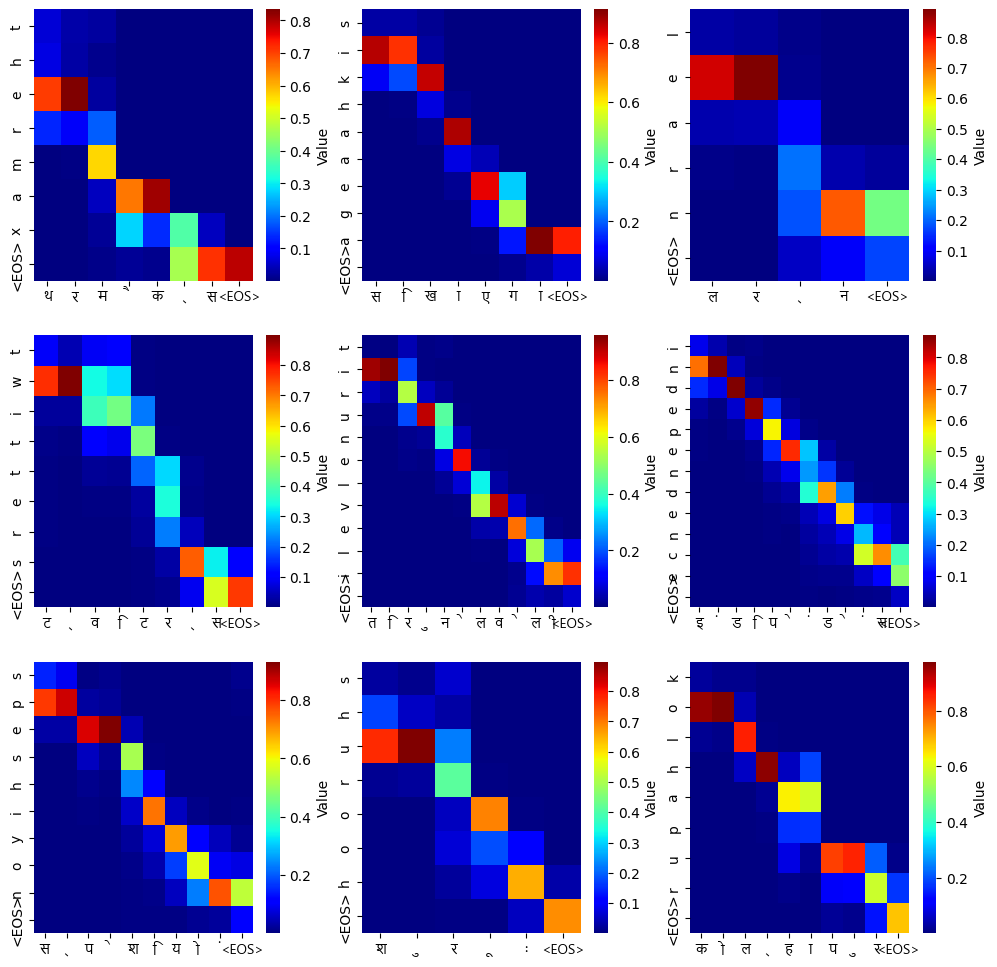

In [40]:
att_matrix(True,test_eng_words,test_hin_words,Encoder1,Decoder1,1,hidden_size,char_embed_size,no_of_layers,True)